In [949]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.utils import class_weight


plt.style.use('seaborn')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [12,8]

## Load Data

In [950]:
users = pd.read_csv('takehome_users.csv',engine = 'python')
engagement = pd.read_csv('takehome_user_engagement.csv',engine='python')

In [951]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [952]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Explore Data


● name: the user's name \
● object_id: the user's id \
● email: email address \
● creation_source: how their account was created. This takes on one 
of 5 values:
1. PERSONAL_PROJECTS: invited to join another user's personal workspace
2. GUEST_INVITE: invited to an organization as a guest (limited permissions)
3. ORG_INVITE: invited to an organization (as a full member)
4. SIGNUP: signed up via the website
5. SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

● creation_time: when they created their account \
● last_session_creation_time: unix timestamp of last login \
● opted_in_to_mailing_list: whether they have opted into receiving marketing emails \
● enabled_for_marketing_drip: whether they are on the regular marketing email drip \
● org_id: the organization (group of users) they belong to \
● invited_by_user_id: which user invited them to join (if applicable).

### Data Overviews

In [953]:
users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [954]:
users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

The data types of some variables need to be specified later.

In [955]:
users.shape

(12000, 10)

In [956]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

There are some missing values in last_session_creation_time and invited_by_user_id.

In [957]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [958]:
engagement.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [959]:
engagement.shape

(207917, 3)

In [960]:
engagement.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [961]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

### Take Care of the Missing Values

In [962]:
#let's take a look at the variable last_session_creation_time
users.last_session_creation_time

0        1.398139e+09
1        1.396238e+09
2        1.363735e+09
3        1.369210e+09
4        1.358850e+09
             ...     
11995    1.378448e+09
11996    1.358275e+09
11997    1.398603e+09
11998    1.338638e+09
11999    1.390727e+09
Name: last_session_creation_time, Length: 12000, dtype: float64

In [963]:
#fill na by mean
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(np.mean(users['last_session_creation_time']))

In [964]:
#invited_by_user_id indicates which user invited them to join applicable, replace missing value by 'no'
users['invited_by_user_id'] = users['invited_by_user_id'].fillna('no')

In [965]:
users.isnull().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

### Use the Right Data Types

In [966]:
users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id             object
dtype: object

In [967]:
users = users.astype({'creation_time':'datetime64[ns]',
                      'object_id':str,
                      'org_id': str})

In [968]:
engagement = engagement.astype({'time_stamp':'datetime64[ns]',
                                'user_id':'str'})

### Only keep users in both data sets

Since we will leverage the engagement data to identify which users are adopted or not, we will focus on those users in both data sets.

In [969]:
common_users = set(users.object_id).intersection(engagement.user_id)
print(users.shape)

(12000, 10)


### Identify Adopated Users

An "adopted user" is a user who logged into the product on three separate days in at least one seven-day period.

In [970]:
engagement = engagement.set_index('time_stamp')

In [971]:
agg_7days = engagement.groupby([pd.Grouper(freq = 'W'),'user_id']).count().reset_index() 
adopted_users = agg_7days.loc[agg_7days.visited >= 3,['user_id']].drop_duplicates().reset_index(drop = True)
adopted_users.head()

,user_id
0,1693
1,11764
2,728
3,5297
4,6171


In [972]:
#identify if users in users dataframe are adopted users
users['adopted_user'] = users.object_id.map(lambda u: 1 if u in adopted_users.user_id.to_list() else 0)

### Frequency Distribution of Adopted User

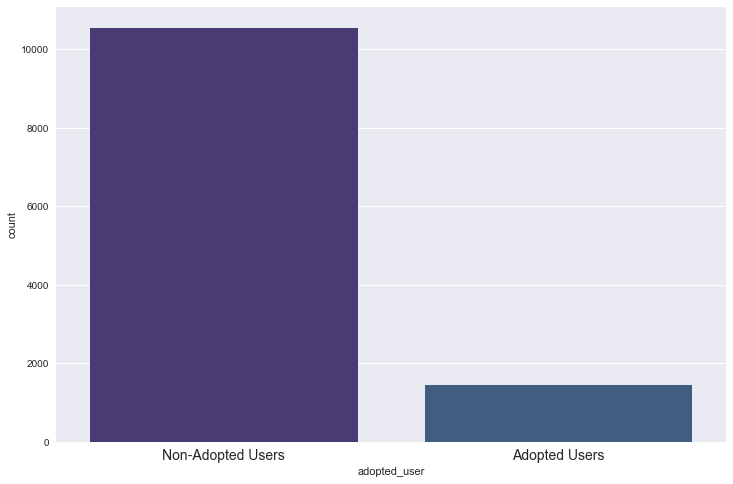

In [973]:
sns.countplot(x = 'adopted_user',data = users)
plt.xticks([0,1],['Non-Adopted Users','Adopted Users'],fontsize = 14);

In [974]:
users.adopted_user.value_counts(normalize =True)

0    0.879583
1    0.120417
Name: adopted_user, dtype: float64

The majority of the users are non-adpoted users, accounting for 88% approximately.

### Explore the relationship between adopted user other variables

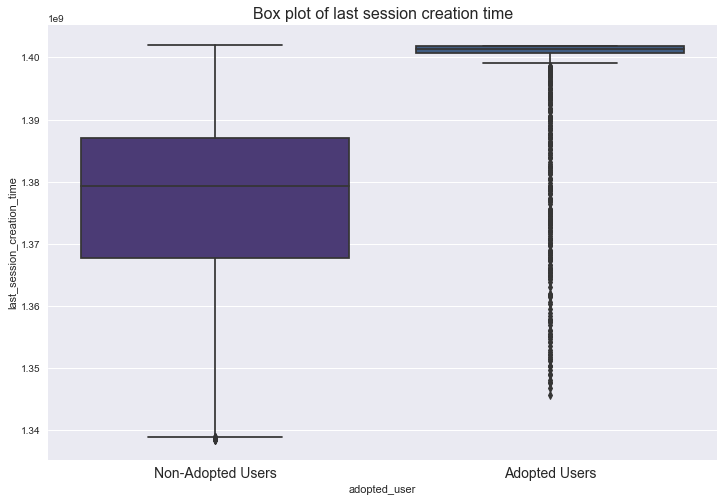

In [975]:
sns.boxplot(y = 'last_session_creation_time',x = 'adopted_user',data = users)
plt.xticks([0,1],['Non-Adopted Users','Adopted Users'],fontsize = 14)
plt.title('Box plot of last session creation time',fontsize = 16);

The distribution of last session creation time for Non-adopted users is evenly distributed while the one for adopted users is extremely skewed and with much higher median.

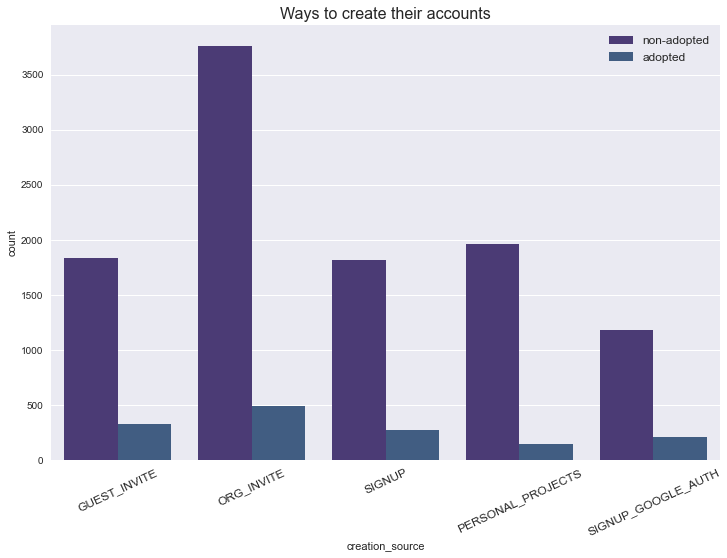

In [976]:
sns.countplot(x = 'creation_source',hue = 'adopted_user',data = users)
plt.legend(['non-adopted','adopted'],fontsize = 12)
plt.xticks(fontsize = 12,rotation = 25)
plt.title('Ways to create their accounts',fontsize = 16);

The most popular way for both groups to create an account is through Origanization invitation.
The second popular way for non adopted users to create an account is through personal projects, while this is the least popular way for adpoted users.

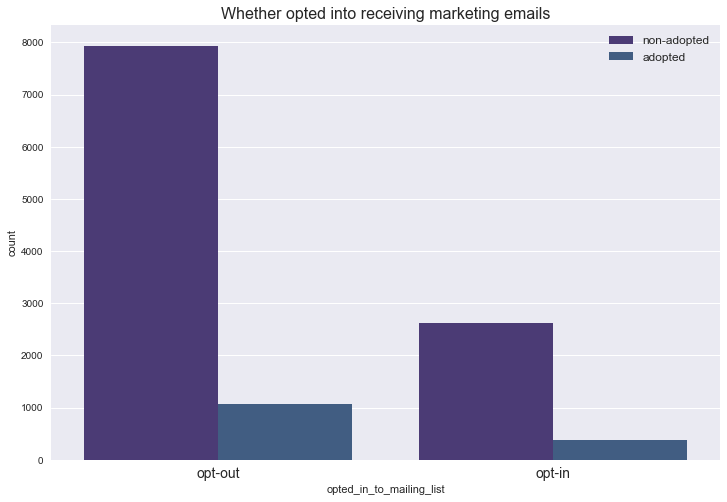

In [977]:
sns.countplot(x = 'opted_in_to_mailing_list',hue = 'adopted_user',data = users)
plt.legend(['non-adopted','adopted'],fontsize = 12)
plt.xticks([0,1],['opt-out','opt-in'],fontsize = 14)
plt.title('Whether opted into receiving marketing emails',fontsize = 16);

Both of non-adopted and adopted users have similar acceptance level of marketing eamils so whether a user optes into receiving marketing emails is may not refect if he will become an adopted users.

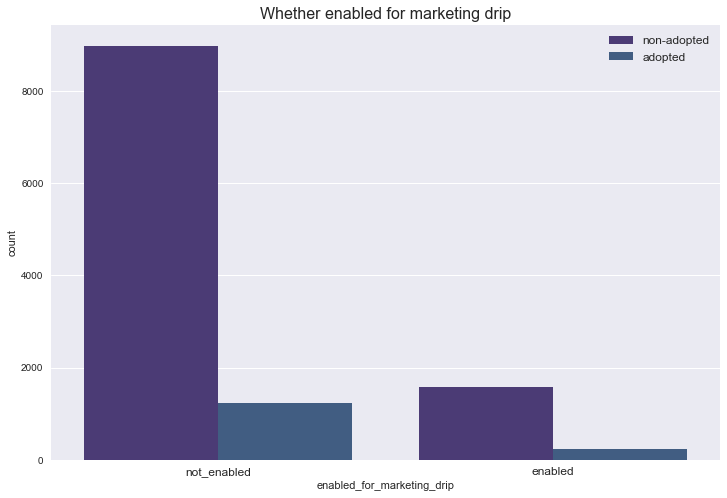

In [978]:
sns.countplot(x = 'enabled_for_marketing_drip',hue = 'adopted_user',data = users)
plt.legend(['non-adopted','adopted'],fontsize = 12)
plt.xticks([0,1],['not_enabled','enabled'],fontsize = 12)
plt.title('Whether enabled for marketing drip',fontsize = 16);

Again,both adopted and non-adopted have similar distributions. Whether enable for marketing drip may not a factor affect adoption.

## Are users invited by apoted users more likely to be an  adopted user?

In [979]:
users['invited_by_adopted_user'] = users.invited_by_user_id.map(lambda x: x in adopted_users.user_id).astype('int')

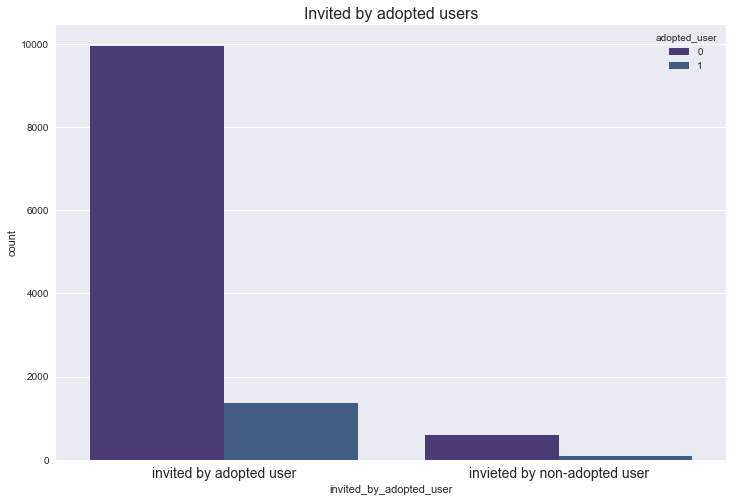

In [980]:
sns.countplot(x= 'invited_by_adopted_user',hue = 'adopted_user',data=users)
plt.xticks([0,1],['invited by adopted user','invieted by non-adopted user'],fontsize=14)
plt.title('Invited by adopted users',fontsize = 16);

## Do the organizations the users belonging to related to adoption?

The nature of a organization dicatates a user's job content. Some job may required higher productivity, organizational and management abilities. Then users holing these jobs may be more likely to continue using the software.

In [981]:
users_by_org = users.groupby(['org_id','adopted_user']).size().unstack(fill_value=0) 
users_ratio_by_org = users_by_org.div(users_by_org.sum(axis = 1),axis = 0)
users_ratio_by_org.columns = ['non-adopted_ratio_by_org','adopted_ratio_by_org']

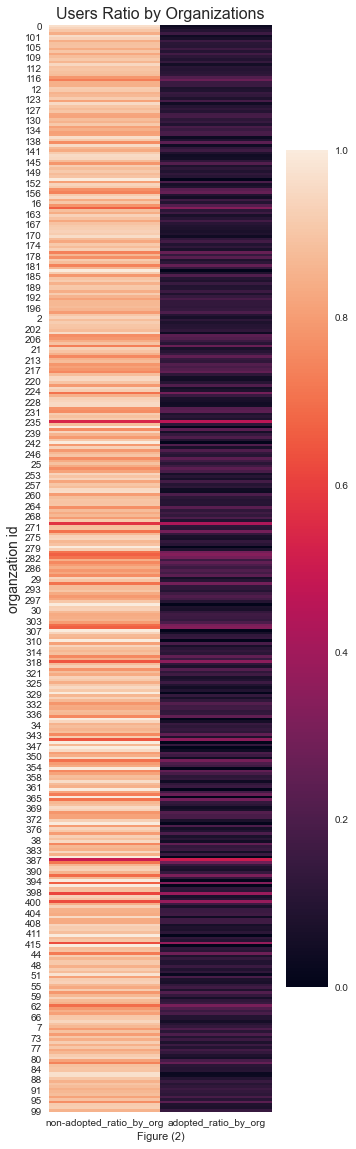

In [982]:
plt.figure(figsize = [5,20])
sns.heatmap(users_ratio_by_org)
#plt.xticks(fontsize = 14,rotation = 25)
plt.title('Users Ratio by Organizations',fontsize = 16)
plt.ylabel('organzation id',fontsize = 14)
plt.xlabel('Figure (2)');

As we can see, there are some variations in the adoption ratio over differnt organization. 
The lighter color of a strip on the right side, the higher adoption ratio for the corresponding organization. 
Let's find out which organizations have adoption rate higher than 0.3.

In [983]:
users_ratio_by_org.loc[users_ratio_by_org.iloc[:,1]>= 0.3]

,non-adopted_ratio_by_org,adopted_ratio_by_org
org_id,,
161,0.666667,0.333333
235,0.538462,0.461538
270,0.571429,0.428571
281,0.666667,0.333333
305,0.692308,0.307692
306,0.666667,0.333333
318,0.647059,0.352941
345,0.642857,0.357143
352,0.700000,0.300000


Users belonging to these organization are potential adopted users.

In [984]:
users = users.merge(users_ratio_by_org.reset_index(),how = 'inner',left_on = 'org_id',right_on= 'org_id')

### Find out the most important factors by random forest classifier

In [985]:
col_names = users.columns[users.columns.map(lambda name: name not in ['creation_time','object_id','name','email','org_id',
                                                                      'invited_by_user_id','adopted_user'])]

In [986]:
X = pd.get_dummies(users.loc[:,col_names],dtype = 'int64')
y = users['adopted_user']

In [987]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y,random_state = 42)

In [988]:
#fit a random forest model
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y = y_train)

# Convert class_weights to a dictionary to pass it to class_weight in model.fit
class_weights = dict(enumerate(class_weights))

clf = RandomForestClassifier(max_depth = 8,random_state = 42,class_weight = class_weights)
clf.fit(X_train,y_train)
pred_y_train = clf.predict(X_train)
pred_y_test = clf.predict(X_test)

In [989]:
#f1 score for training
metrics.f1_score(y_train,pred_y_train)

0.7534675615212528

In [990]:
#f1 score for test set
metrics.f1_score(y_test,pred_y_test)

0.7038183694530443

The classifier perfroms consistently on both of the training set and test set.
Next, let's a look at the most important features selected by the classifier.

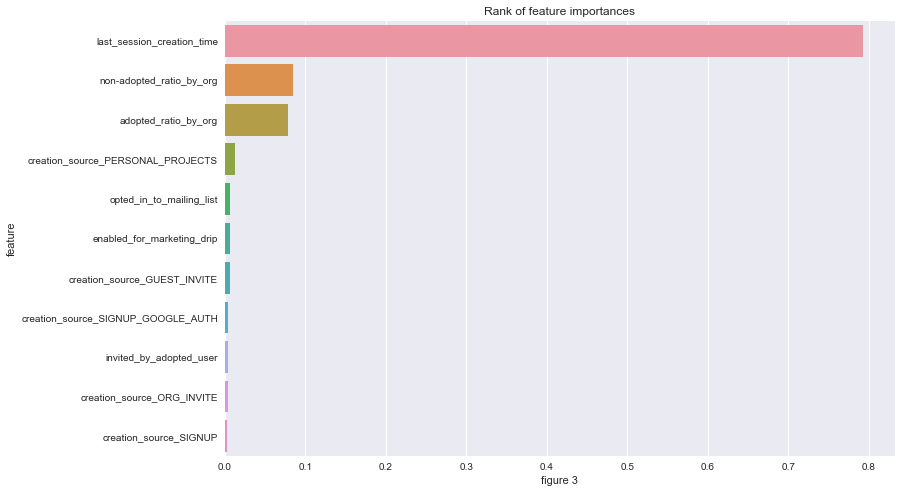

In [991]:
rank = pd.DataFrame({'feature_importances': clf.feature_importances_,
                     'feature' : X.columns}).sort_values(by = 'feature_importances',ascending=False)

sns.barplot(y = 'feature',x = 'feature_importances', data = rank,orient ='h')
plt.xlabel('figure 3')
plt.title('Rank of feature importances');

The results by the random forest classifier is coherent with the exploration above.
Last session creation time is the most important feature deciding user adoption, followed by the organiztion a user belonges to. Also, the creation source may also ma